# E14. Human Segmentation

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### 사진
---
- 인물사진: 니콜라스 케이지 ? 사진
- 앵무새 사진: 히아신스 마카우, 썬코뉴어, 사랑앵무
- 강아지 사진: 강아지
- 배경 사진: 우주(APOD)

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/e/human_segmentation/images/nick.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(380, 512, 3)


In [35]:
macaw_path = os.getenv("HOME")+"/aiffel/e/human_segmentation/images/hyacinth_macaw2.jpg"
macaw_orig = cv2.imread(macaw_path)
print(macaw_orig.shape)

(474, 474, 3)


In [56]:
sun_conure_path = os.getenv("HOME")+"/aiffel/e/human_segmentation/images/sunconure.jpg"
sun_conure_orig = cv2.imread(sun_conure_path)
print(sun_conure_orig.shape)

(1024, 683, 3)


In [57]:
budgie_path = os.getenv("HOME")+"/aiffel/e/human_segmentation/images/budgie.jpg"
budgie_orig = cv2.imread(budgie_path)
print(budgie_orig.shape)

(1000, 1238, 3)


In [62]:
doge_path = os.getenv("HOME")+"/aiffel/e/human_segmentation/images/doge.jpeg"
doge_orig = cv2.imread(doge_path)
print(doge_orig.shape)

(183, 275, 3)


In [4]:
space_path = os.getenv("HOME")+"/aiffel/e/human_segmentation/images/andromeda2.jpg"
space_orig = cv2.imread(space_path)
print(space_orig.shape)

(535, 800, 3)


### DeelLabModel

In [5]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [6]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/e/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/e/human_segmentation/models
model loaded successfully!


In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [8]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(380, 512, 3) (380, 513, 3) 15


background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요.

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 마스크를 만들고 시각화해 볼까요?



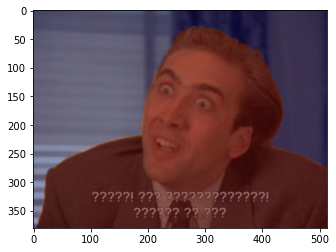

In [29]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

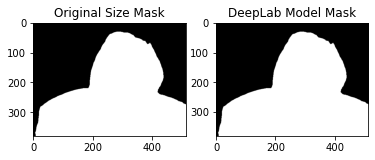

In [30]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

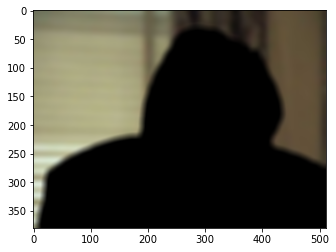

In [31]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

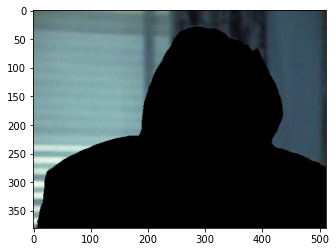

In [32]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

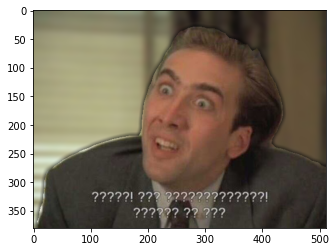

In [33]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

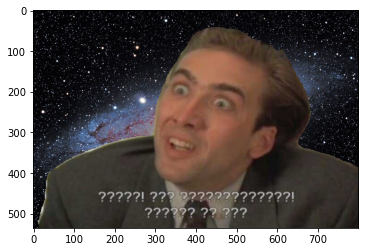

In [34]:
img_resized = cv2.resize(
    img_orig, (space_orig.shape[1], space_orig.shape[0]))
img_mask_resized = cv2.resize(
    img_mask_color, (space_orig.shape[1], space_orig.shape[0]))

space_concat = np.where(
    img_mask_resized == 255, img_resized, space_orig)

plt.imshow(cv2.cvtColor(space_concat, cv2.COLOR_BGR2RGB))
plt.show()

__히아신스 마카우__

In [38]:
macaw_resized, macaw_seg_map = MODEL.run(macaw_orig)
print (macaw_orig.shape, macaw_resized.shape, macaw_seg_map.max())

(474, 474, 3) (513, 513, 3) 3


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


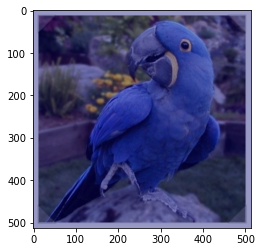

In [41]:
macaw_show = macaw_resized.copy()
macaw_seg_map = np.where(macaw_seg_map == 12, 12, 0)
macaw_mask = macaw_seg_map * (255/macaw_seg_map.max()) # 255 normalization
macaw_mask = macaw_mask.astype(np.uint8)
macaw_color_mask = cv2.applyColorMap(macaw_mask, cv2.COLORMAP_JET)
macaw_show = cv2.addWeighted(macaw_show, 0.6, macaw_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(macaw_show, cv2.COLOR_BGR2RGB))
plt.show()

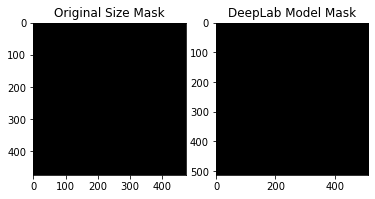

In [42]:
macaw_mask_up = cv2.resize(macaw_mask, macaw_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, macaw_mask_up = cv2.threshold(macaw_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(macaw_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(macaw_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

히아신스 마카우는 정상적으로 segmentation 이 되지 않았다.

__썬코뉴어__

In [50]:
sun_conure_resized, sun_conure_seg_map = MODEL.run(sun_conure_orig)
print (sun_conure_orig.shape, sun_conure_resized.shape, sun_conure_seg_map.max())

(1024, 683, 3) (513, 342, 3) 3


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


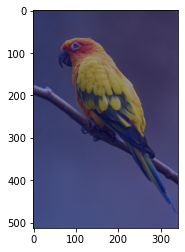

In [51]:
sun_conure_show = sun_conure_resized.copy()
sun_conure_seg_map = np.where(sun_conure_seg_map == 12, 12, 0)
sun_conure_mask = sun_conure_seg_map * (255/sun_conure_seg_map.max()) # 255 normalization
sun_conure_mask = sun_conure_mask.astype(np.uint8)
sun_conure_color_mask = cv2.applyColorMap(sun_conure_mask, cv2.COLORMAP_JET)
sun_conure_show = cv2.addWeighted(sun_conure_show, 0.6, sun_conure_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(sun_conure_show, cv2.COLOR_BGR2RGB))
plt.show()

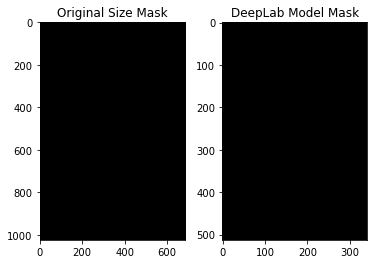

In [52]:
sun_conure_mask_up = cv2.resize(sun_conure_mask, sun_conure_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, sun_conure_mask_up = cv2.threshold(sun_conure_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(sun_conure_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(sun_conure_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

썬코뉴어도 segmentation이 진행되지 않는다. 앵무류는 워낙 변화무쌍하여 힘든 것으로 추정하였다.

다만 [논문](https://arxiv.org/pdf/1502.02734.pdf) 8페이지에 사랑앵무 segmentation 이 확실히 되었던 것을 확인했기에 한번 더 시도해보기로 한다.

__사랑앵무__

In [58]:
budgie_resized, budgie_seg_map = MODEL.run(budgie_orig)
print (budgie_orig.shape, budgie_resized.shape, budgie_seg_map.max())

(1000, 1238, 3) (414, 513, 3) 3


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


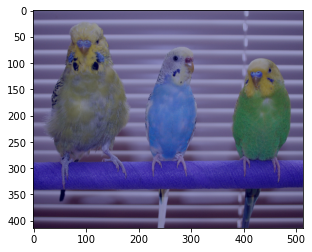

In [59]:
budgie_show = budgie_resized.copy()
budgie_seg_map = np.where(budgie_seg_map == 12, 12, 0)
budgie_mask = budgie_seg_map * (255/budgie_seg_map.max()) # 255 normalization
budgie_mask = budgie_mask.astype(np.uint8)
budgie_color_mask = cv2.applyColorMap(budgie_mask, cv2.COLORMAP_JET)
budgie_show = cv2.addWeighted(budgie_show, 0.6, budgie_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(budgie_show, cv2.COLOR_BGR2RGB))
plt.show()

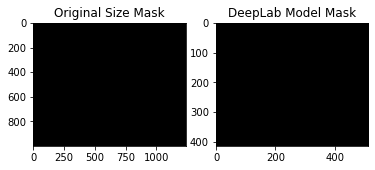

In [61]:
budgie_mask_up = cv2.resize(budgie_mask, budgie_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, budgie_mask_up = cv2.threshold(budgie_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(budgie_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(budgie_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

마찬가지로 되지 않는다. 일반적인 강아지 사진을 써 보아야겠다.

__강아지__

## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항    
상세기준

---
### 1. 인물모드 사진을 성공적으로 제작하였다.

아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
### 2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.

인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
### 3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.

추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.